In [4]:
import numpy as np
import math
from scipy.stats import norm,t
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


## Estimating values with confidence

### Parameter of a binomial distribution

In [55]:

def get_confidence_interval(dist,ci,use_tt = False):
    # mean of the population
    mean = np.mean(dist)
    # standard deviation of the population
    sd = np.std(dist) 
    # central limit theorem, the sampling of the mean will follow a normal distribution 
    # of parameters mean, and sd /sqrt(n)
    quant = (1-(ci))/2
    if not use_tt:
        high_norm_percentile = norm.ppf(ci+quant,mean, sd/np.sqrt(len(dist)))
        low_norm_percentile = norm.ppf(quant, mean, sd/np.sqrt(len(dist)))
    else:
        high_norm_percentile = t.ppf(ci+quant,df = len(dist)-1 ,loc = mean, scale = sd/np.sqrt(len(dist)))
        low_norm_percentile = t.ppf(quant, df = len(dist)-1,loc = mean,scale =  sd/np.sqrt(len(dist)))

    return low_norm_percentile,high_norm_percentile


In [65]:
dist = np.random.binomial(n = 1,p = 0.45,size = 100)
get_confidence_interval(dist,0.95)

(0.29440276921149167, 0.48559723078850836)

In [66]:
get_confidence_interval(dist,0.95,use_tt = True)

(0.29321983090298487, 0.48678016909701516)

In [3]:
# true value of the distribution
true_p = 0.23

def simulate(true_p,n,ci):
    intervals_containing_true_p = []
    cis = []
    for i in range(10000):
        # generate random bernouilli distributions with that p
        experiments = np.random.binomial(n = 1,p = true_p,size = n)
        low_int, high_int = get_confidence_interval(experiments,ci)
        # count if the actual value falls in the confidence inteval
        cis.append([low_int,high_int])
        if true_p>low_int and true_p<high_int:
            intervals_containing_true_p.append(1)
        else:
            intervals_containing_true_p.append(0)
            
    cis = pd.DataFrame(cis).reset_index() 
    cis = cis.rename(columns = {0:"l_ci",1:"h_ci","index":"it"})
    cis["param"] = (cis["h_ci"] + cis["l_ci"])/2
    print(np.mean(intervals_containing_true_p)*100)
    return cis

In [4]:
cis = simulate(true_p,100,0.95)

95.50999999999999


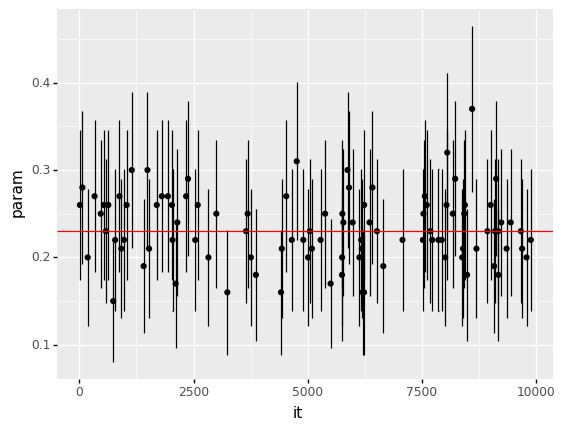

<ggplot: (8747493958169)>

In [5]:
ggplot(cis.sample(100),aes(x = "it")) + geom_point(aes(y = "param" )) + geom_errorbar(aes(ymin = "l_ci",ymax = "h_ci")) + geom_hline(yintercept=true_p,color = "red")

76.34


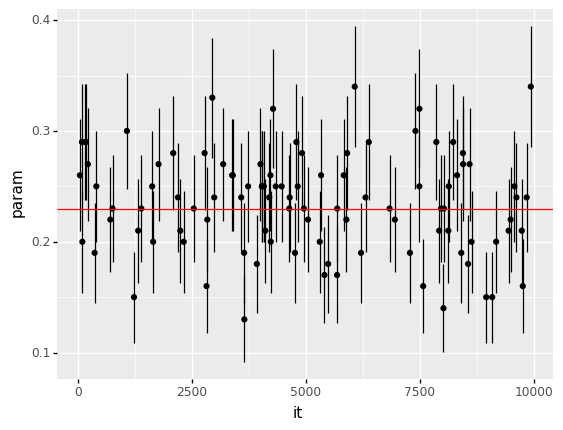

<ggplot: (8747493958232)>

In [6]:
cis = simulate(true_p,100,0.75)
ggplot(cis.sample(100),aes(x = "it")) + geom_point(aes(y = "param" )) + geom_errorbar(aes(ymin = "l_ci",ymax = "h_ci")) + geom_hline(yintercept=true_p,color = "red")

95.42


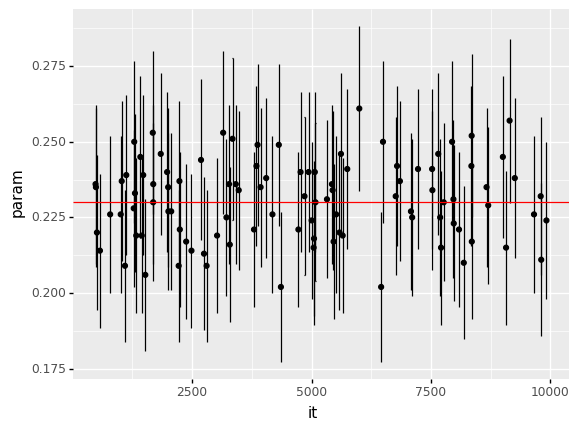

<ggplot: (8747493966041)>

In [7]:
cis = simulate(true_p,1000,0.95)
ggplot(cis.sample(100),aes(x = "it")) + geom_point(aes(y = "param" )) + geom_errorbar(aes(ymin = "l_ci",ymax = "h_ci")) + geom_hline(yintercept=true_p,color = "red")

### DIfference between the means of unpaired distributions

In [49]:
def get_confidence_interval_diff(dist_1,dist_2,ci):
    # mean of the populations
    mean_1 = np.mean(dist_1)
    mean_2 = np.mean(dist_2)
    
    diff_means =mean_1 - mean_2

    # central limit theorem, the sampling of the mean will follow a normal distribution 
    # of parameters mean, and sd /sqrt(n)
    sd_1 = np.std(dist_1)/np.sqrt(len(dist_1))
    sd_2 = np.std(dist_2)/np.sqrt(len(dist_2))
    
    # the standard deviation of the sum of independent normals is the square of the sum of their variances
    diff_sd = np.sqrt(sd_1**2 + sd_2**2)


    quant = (1-(ci))/2
    

    high_norm_percentile = norm.ppf(ci+quant,diff_means, diff_sd)
    low_norm_percentile = norm.ppf(quant, diff_means, diff_sd)

    return low_norm_percentile,high_norm_percentile

In [52]:
dist_1 = np.random.binomial(n = 1,p = 0.55,size = 988)
dist_2 = np.random.binomial(n = 1,p = 0.37,size = 247)

In [53]:
get_confidence_interval_diff(dist_1,dist_2,0.95)

(0.11291062171827658, 0.24943755641937515)

## Difference between the means of paired distribution

In [101]:
dist_1 = np.random.normal(0.4,1,1000)
dist_2 = np.random.normal(0.35,1,1000)

In [102]:
diff_dist = dist_1 - dist_2

In general the confidence intervals are wider for the paired test than for the unpaired one:

In [107]:
get_confidence_interval(diff_dist,0.95)

(-0.02408912586507847, 0.15227542753605988)

In [108]:
get_confidence_interval_diff(dist_1,dist_2,0.95)

(-0.024973492698643227, 0.15315979436962468)

In [109]:
n_contains_paired = 0
n_contains_unpaired = 0
for i in range(10000):
    dist_1 = np.random.normal(0.4,1,1000)
    dist_2 = np.random.normal(0.35,1,1000)
    diff_dist = dist_1 - dist_2
    paired_ci = get_confidence_interval(diff_dist,0.95)
    unpaired_ci = get_confidence_interval_diff(dist_1,dist_2,0.95)
    if 0.05>=paired_ci[0] and 0.05<=paired_ci[1]:
        n_contains_paired+=1
        
    if 0.05>=unpaired_ci[0] and 0.05<=unpaired_ci[1]:
        n_contains_unpaired+=1

In [111]:
n_contains_unpaired / 10000

0.9512

In [112]:
n_contains_paired / 10000

0.9502

## Hypothesis testing

### Parameter of binomial distribution larger than something

In [92]:
value = 0.52

0.5609037328094303

In [96]:
def get_p_dist_larger_than_value(dist,value):
    mean = np.mean(dist)
    sd = np.std(dist) 
    high_norm_percentile = norm.cdf(value,mean, sd/np.sqrt(len(dist)))
    return high_norm_percentile

In [116]:
dist = np.random.binomial(n = 1,p = 0.56,size = 1018)
get_p_dist_larger_than_value([1]*570 + [0]*448,value)

0.005144423218331174

### Parameter of one binomial distribution larger than parameter of another

In [467]:
## This method computes the distribution of the difference of means 
## (which is normal because the original distribution are independent)
## and computes where the actual difference falls

def get_p_param_different_1(dist_1,dist_2):    
    # mean of the populations
    mean_1 = np.mean(dist_1)
    mean_2 = np.mean(dist_2)
    
    diff_means =mean_1 - mean_2

    # central limit theorem, the sampling of the mean will follow a normal distribution 
    # of parameters mean, and sd /sqrt(n)
    sd_1 = np.std(dist_1)/np.sqrt(len(dist_1))
    sd_2 = np.std(dist_2)/np.sqrt(len(dist_2))
    
    diff_sd = np.sqrt(sd_1**2 + sd_2**2)

    
    p_value = norm.cdf(0 ,diff_means, diff_sd)
    if p_value>=0.5:
        p_value = 1-p_value
    return diff_sd,p_value*2

In [468]:
## This method is a permutation test: we assume that under the null hypothesis the means are the same:
## we mix the distributions and compute permuted groups and the distribution of means of them

def get_p_param_different_2(dist_1,dist_2):    
    # mean of the populations
    mean_1 = np.mean(dist_1)
    mean_2 = np.mean(dist_2)
    mean_diff = mean_1 - mean_2
    dist_1_2 = np.concatenate([dist_1,dist_2])
    
    differences = []
    for i in range(1000000):
        dist_1_2 = np.random.permutation(dist_1_2)
        differences.append(np.mean(dist_1_2[:len(dist_1)]) - np.mean(dist_1_2[len(dist_1):]))
    differences = np.array(differences)
    if len(differences[differences>mean_diff]) >= len(differences[differences<mean_diff]):
        return differences,len(differences[differences<mean_diff])*2 / len(differences)
    else:
        return differences,len(differences[differences>mean_diff])*2 / len(differences)
    

In [469]:
n = 500

dist_1 = np.random.binomial(n = 1,p = 0.46,size = n)
dist_2 = np.random.binomial(n = 1,p = 0.46,size = n)

dist_1 = np.random.normal(2,,n)
dist_2 = np.random.normal(0,1,n)

dist_1 = np.random.beta(a = 22.1,b = 40,size = n)
dist_1 = np.random.beta(a = 22,b = 40,size = n)

In [470]:


diff_sd,p_value_1 = get_p_param_different_1(dist_1,dist_2)
differences,p_value_2 = get_p_param_different_2(dist_1,dist_2)

print(p_value_1)
print(p_value_2)

3.82211196272912e-194
0.0


In [472]:
np.std(differences)

0.08801962986286868

In [464]:
ttest_ind(dist_1,dist_2,equal_var=False)

Ttest_indResult(statistic=-1.2716366977667322, pvalue=0.20499388800258736)

In [132]:
success  =0
for i in range(10000):
    dist_1 = np.random.normal(1,10000,n)
    dist_2 = np.random.normal(1,1,n)

    p_value = ttest_ind(dist_1,dist_2,equal_var=False)[1]
    if p_value<0.05:
        success+=1
        
success/10000

0.0485

### Power

In [134]:
n = 1000
k = 5000
alpha = 0.05
power_results = []

for effect in range(-10,11,1):
    detections = 0
    for i in range(k):
        dist_1 = np.random.normal(2,1,n)
        dist_2 = np.random.normal(2,1,n)

        effect_dist_2 = dist_2 + np.mean(dist_2)*(effect/100)
        p_value = ttest_ind(dist_1,effect_dist_2,equal_var=False)[1]
        if p_value<=alpha:
            detections+=1
    power_results.append({"effect %":(effect),"detection_rate":(detections*100)/k})
        

In [92]:
np.std(dist_1)

1.0

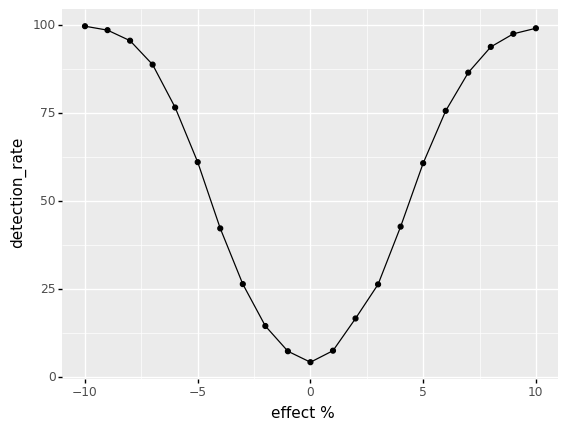

<ggplot: (8744875619687)>

In [135]:
power_results = pd.DataFrame(power_results)
ggplot(power_results,aes(x = "effect %",y = "detection_rate")) + geom_line() + geom_point()

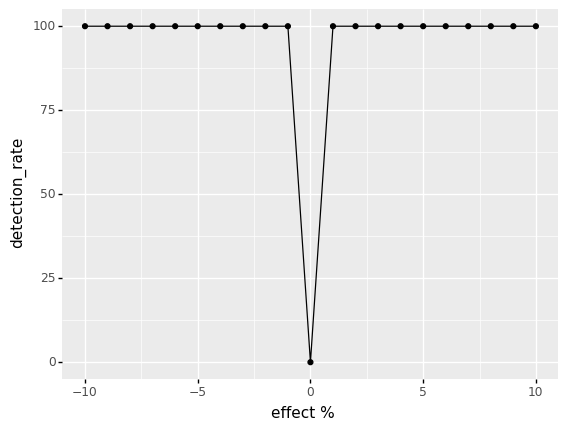

<ggplot: (8744877227801)>

In [87]:
power_results = pd.DataFrame(power_results)
ggplot(power_results,aes(x = "effect %",y = "detection_rate")) + geom_line() + geom_point()

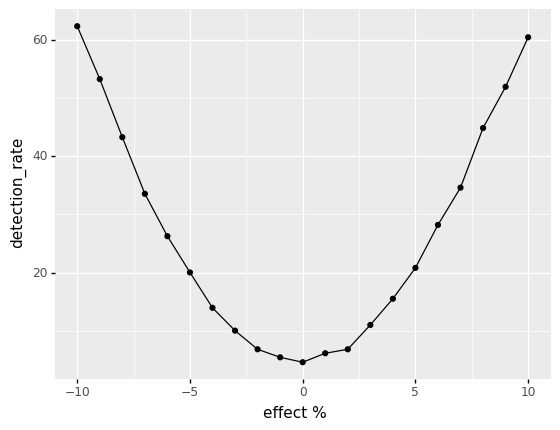

<ggplot: (8744875710275)>

In [82]:
power_results = pd.DataFrame(power_results)
ggplot(power_results,aes(x = "effect %",y = "detection_rate")) + geom_line() + geom_point()

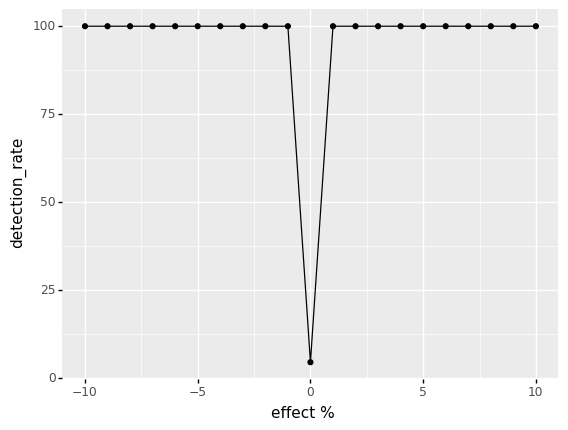

<ggplot: (8744875800058)>

In [85]:
power_results = pd.DataFrame(power_results)
ggplot(power_results,aes(x = "effect %",y = "detection_rate")) + geom_line() + geom_point()

In [67]:
dist_1 = np.random.normal(0,1,n)
dist_2 = np.random.normal(0,1,n)
effect = -10
effect_dist_2 = dist_2 - np.mean(dist_2)

In [65]:
np.mean(dist_2)

-0.009569061918439892